In [1]:
import pandas as pd
import numpy as np
import random
import os

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import lightgbm as lgb
import catboost as ctb
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')


In [2]:
TARGET = 'Survived'

N_ESTIMATORS = 1000
N_SPLITS = 10
SEED = 2021
EARLY_STOPPING_ROUNDS = 100
VERBOSE = 100

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

In [4]:
train_df = pd.read_csv('D:/Python/Anaconda/Kaggle/Working/Tabular Playground Apr 2021/data/train.csv')
test_df = pd.read_csv('D:/Python/Anaconda/Kaggle/Working/Tabular Playground Apr 2021/data/test.csv')
submission = pd.read_csv('D:/Python/Anaconda/Kaggle/Working/Tabular Playground Apr 2021/data/sample_submission.csv')
test_df[TARGET] = pd.read_csv("D:/Python/Anaconda/Kaggle/Working/Tabular Playground Apr 2021/data/sub.csv")[TARGET]

all_df = pd.concat([train_df, test_df]).reset_index(drop=True)

In [5]:
# Age fillna with mean age for each class
all_df['Age'] = all_df['Age'].fillna(all_df['Age'].mean())

# Cabin, fillna with 'X' and take first letter
all_df['Cabin'] = all_df['Cabin'].fillna('X').map(lambda x: x[0].strip())

# Ticket, fillna with 'X', split string and take first split 
all_df['Ticket'] = all_df['Ticket'].fillna('X').map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')

# Fare, fillna with mean value
fare_map = all_df[['Fare', 'Pclass']].dropna().groupby('Pclass').median().to_dict()
all_df['Fare'] = all_df['Fare'].fillna(all_df['Pclass'].map(fare_map['Fare']))
all_df['Fare'] = np.log1p(all_df['Fare'])

# Embarked, fillna with 'X' value
all_df['Embarked'] = all_df['Embarked'].fillna('X')

# Name, take only surnames
all_df['Name'] = all_df['Name'].map(lambda x: x.split(',')[0])

In [6]:
label_cols = ['Name', 'Ticket', 'Sex']
onehot_cols = ['Cabin', 'Embarked']
numerical_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [7]:
def label_encoder(c):
    le = LabelEncoder()
    return le.fit_transform(c)

scaler = StandardScaler()

onehot_encoded_df = pd.get_dummies(all_df[onehot_cols])
label_encoded_df = all_df[label_cols].apply(label_encoder)
numerical_df = pd.DataFrame(scaler.fit_transform(all_df[numerical_cols]), columns=numerical_cols)
target_df = all_df[TARGET]

all_df = pd.concat([numerical_df, label_encoded_df, onehot_encoded_df, target_df], axis=1)

In [8]:
params = {
    'metric': 'binary_logloss',
    'n_estimators': N_ESTIMATORS,
    'objective': 'binary',
    'random_state': SEED,
    'learning_rate': 0.01,
    'min_child_samples': 150,
    'reg_alpha': 3e-5,
    'reg_lambda': 9e-2,
    'num_leaves': 20,
    'max_depth': 16,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 2,
    'max_bin': 240,
}

In [9]:
lgb_oof = np.zeros(train_df.shape[0])
lgb_preds = np.zeros(test_df.shape[0])
feature_importances = pd.DataFrame()

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(skf.split(all_df, all_df[TARGET])):
    print(f"===== FOLD {fold} =====")
    oof_idx = np.array([idx for idx in valid_idx if idx < train_df.shape[0]])
    preds_idx = np.array([idx for idx in valid_idx if idx >= train_df.shape[0]])

    X_train, y_train = all_df.iloc[train_idx].drop(TARGET, axis=1), all_df.iloc[train_idx][TARGET]
    X_valid, y_valid = all_df.iloc[oof_idx].drop(TARGET, axis=1), all_df.iloc[oof_idx][TARGET]
    X_test = all_df.iloc[preds_idx].drop(TARGET, axis=1)
    
    pre_model = lgb.LGBMRegressor(**params)
    pre_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train),(X_valid, y_valid)],
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose=VERBOSE
    )

    params2 = params.copy()
    params2['learning_rate'] = params['learning_rate'] * 0.1
    model = lgb.LGBMRegressor(**params2)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train),(X_valid, y_valid)],
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose=VERBOSE,
        init_model=pre_model
    )
    
    fi_tmp = pd.DataFrame()
    fi_tmp["feature"] = model.feature_name_
    fi_tmp["importance"] = model.feature_importances_
    fi_tmp["fold"] = fold
    fi_tmp["seed"] = SEED
    feature_importances = feature_importances.append(fi_tmp)
    
    lgb_oof[oof_idx] = model.predict(X_valid)
    lgb_preds[preds_idx-train_df.shape[0]] = model.predict(X_test)
    
    acc_score = accuracy_score(y_valid, np.where(lgb_oof[oof_idx]>0.5, 1, 0))
    print(f"===== ACCURACY SCORE {acc_score:.6f} =====\n")
    
acc_score = accuracy_score(all_df[:train_df.shape[0]][TARGET], np.where(lgb_oof>0.5, 1, 0))
print(f"===== ACCURACY SCORE {acc_score:.6f} =====")

===== FOLD 0 =====
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.403109	valid_1's binary_logloss: 0.510845
[200]	training's binary_logloss: 0.338224	valid_1's binary_logloss: 0.491323
[300]	training's binary_logloss: 0.317709	valid_1's binary_logloss: 0.495711
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.336458	valid_1's binary_logloss: 0.491162
Training until validation scores don't improve for 100 rounds
[300]	training's binary_logloss: 0.333547	valid_1's binary_logloss: 0.491398
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.33637	valid_1's binary_logloss: 0.491167
===== ACCURACY SCORE 0.776645 =====

===== FOLD 1 =====
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.403276	valid_1's binary_logloss: 0.509775
[200]	training's binary_logloss: 0.338505	valid_1's binary_logloss: 0.489541
[300]	training's binary_logloss: 0.31802	valid_1's bin

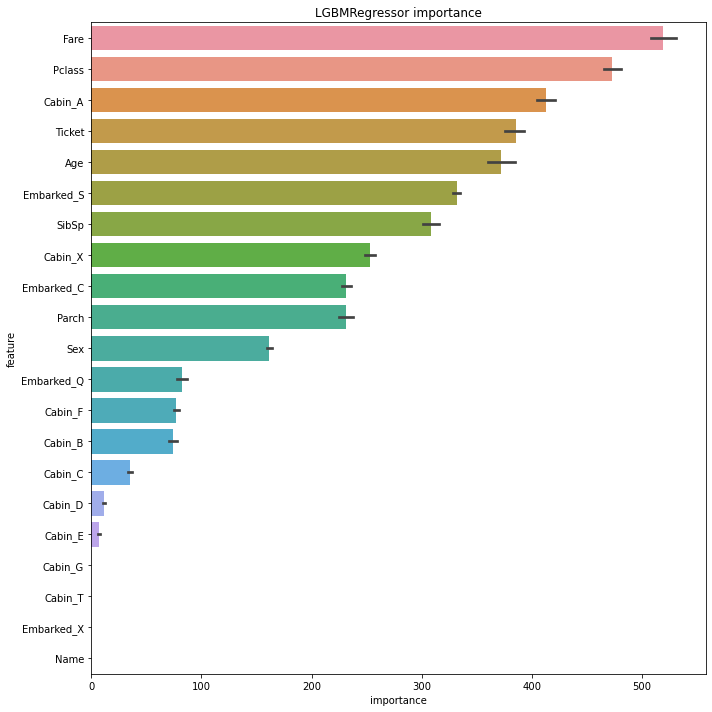

In [10]:
# just to get ideas to improve
order = list(feature_importances.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importances, order=order)
plt.title("{} importance".format("LGBMRegressor"))
plt.tight_layout()

In [11]:
params = {
    'bootstrap_type': 'Poisson',
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'random_seed': SEED,
    'task_type': 'GPU',
    'max_depth': 8,
    'learning_rate': 0.01,
    'n_estimators': N_ESTIMATORS,
    'max_bin': 280,
    'min_data_in_leaf': 64,
    'l2_leaf_reg': 0.01,
    'subsample': 0.8
}

In [12]:
ctb_oof = np.zeros(train_df.shape[0])
ctb_preds = np.zeros(test_df.shape[0])
feature_importances = pd.DataFrame()

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(skf.split(all_df, all_df[TARGET])):
    print(f"===== FOLD {fold} =====")
    oof_idx = np.array([idx for idx in valid_idx if idx < train_df.shape[0]])
    preds_idx = np.array([idx for idx in valid_idx if idx >= train_df.shape[0]])

    X_train, y_train = all_df.iloc[train_idx].drop(TARGET, axis=1), all_df.iloc[train_idx][TARGET]
    X_valid, y_valid = all_df.iloc[oof_idx].drop(TARGET, axis=1), all_df.iloc[oof_idx][TARGET]
    X_test = all_df.iloc[preds_idx].drop(TARGET, axis=1)
    
    model = ctb.CatBoostClassifier(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_valid, y_valid)],
              use_best_model=True,
              early_stopping_rounds=EARLY_STOPPING_ROUNDS,
              verbose=VERBOSE
              )
    
    fi_tmp = pd.DataFrame()
    fi_tmp["feature"] = X_test.columns.to_list()
    fi_tmp["importance"] = model.get_feature_importance()
    fi_tmp["fold"] = fold
    fi_tmp["seed"] = SEED
    feature_importances = feature_importances.append(fi_tmp)
    
    ctb_oof[oof_idx] = model.predict(X_valid)
    ctb_preds[preds_idx-train_df.shape[0]] = model.predict(X_test)
    
    acc_score = accuracy_score(y_valid, np.where(ctb_oof[oof_idx]>0.5, 1, 0))
    print(f"===== ACCURACY SCORE {acc_score:.6f} =====\n")
    
acc_score = accuracy_score(all_df[:train_df.shape[0]][TARGET], np.where(ctb_oof>0.5, 1, 0))
print(f"===== ACCURACY SCORE {acc_score:.6f} =====")

===== FOLD 0 =====
0:	learn: 0.6842181	test: 0.6866368	best: 0.6866368 (0)	total: 24.3ms	remaining: 24.3s
100:	learn: 0.3501620	test: 0.4925553	best: 0.4925553 (100)	total: 2.07s	remaining: 18.4s
200:	learn: 0.3148944	test: 0.4984118	best: 0.4919061 (117)	total: 4.26s	remaining: 16.9s
bestTest = 0.4919061282
bestIteration = 117
Shrink model to first 118 iterations.
===== ACCURACY SCORE 0.778822 =====

===== FOLD 1 =====
0:	learn: 0.6842314	test: 0.6866284	best: 0.6866284 (0)	total: 24.4ms	remaining: 24.3s
100:	learn: 0.3507240	test: 0.4914024	best: 0.4914024 (100)	total: 1.97s	remaining: 17.6s
200:	learn: 0.3153185	test: 0.4959981	best: 0.4900809 (123)	total: 4.05s	remaining: 16.1s
bestTest = 0.4900808642
bestIteration = 123
Shrink model to first 124 iterations.
===== ACCURACY SCORE 0.781003 =====

===== FOLD 2 =====
0:	learn: 0.6842237	test: 0.6866177	best: 0.6866177 (0)	total: 21.3ms	remaining: 21.3s
100:	learn: 0.3506747	test: 0.4907978	best: 0.4907978 (100)	total: 1.99s	remaining: 

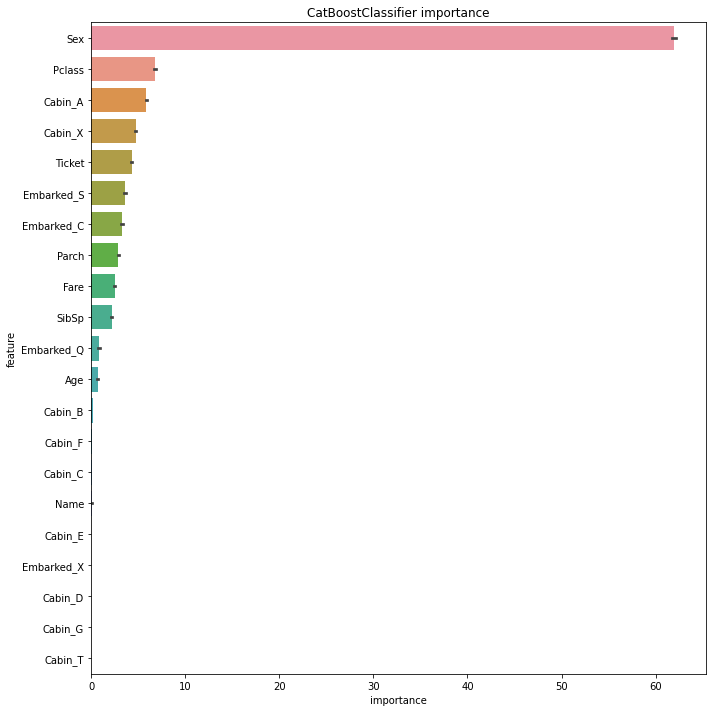

In [13]:
# just to get ideas to improve
order = list(feature_importances.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importances, order=order)
plt.title("{} importance".format("CatBoostClassifier"))
plt.tight_layout()

In [14]:
# Tuning the DecisionTreeClassifier by the GridSearchCV
parameters = {
    'max_depth': np.arange(2, 5, dtype=int),
    'min_samples_leaf':  np.arange(2, 5, dtype=int)
}

classifier = DecisionTreeClassifier(random_state=2021)

model = GridSearchCV(
    estimator=classifier,
    param_grid=parameters,
    scoring='accuracy',
    cv=10,
    n_jobs=-1)
model.fit(X_train, y_train)

best_parameters = model.best_params_
print(best_parameters)

{'max_depth': 4, 'min_samples_leaf': 2}


In [15]:
dtm_oof = np.zeros(train_df.shape[0])
dtm_preds = np.zeros(test_df.shape[0])
feature_importances = pd.DataFrame()

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(skf.split(all_df, all_df[TARGET])):
    print(f"===== FOLD {fold} =====")
    oof_idx = np.array([idx for idx in valid_idx if idx < train_df.shape[0]])
    preds_idx = np.array([idx for idx in valid_idx if idx >= train_df.shape[0]])

    X_train, y_train = all_df.iloc[train_idx].drop(TARGET, axis=1), all_df.iloc[train_idx][TARGET]
    X_valid, y_valid = all_df.iloc[oof_idx].drop(TARGET, axis=1), all_df.iloc[oof_idx][TARGET]
    X_test = all_df.iloc[preds_idx].drop(TARGET, axis=1)
    
    model = DecisionTreeClassifier(
        max_depth=best_parameters['max_depth'],
        min_samples_leaf=best_parameters['min_samples_leaf'],
        random_state=SEED
    )
    model.fit(X_train, y_train)
    
    dtm_oof[oof_idx] = model.predict(X_valid)
    dtm_preds[preds_idx-train_df.shape[0]] = model.predict(X_test)
    
    acc_score = accuracy_score(y_valid, np.where(dtm_oof[oof_idx]>0.5, 1, 0))
    print(f"===== ACCURACY SCORE {acc_score:.6f} =====\n")
    
acc_score = accuracy_score(all_df[:train_df.shape[0]][TARGET], np.where(dtm_oof>0.5, 1, 0))
print(f"===== ACCURACY SCORE {acc_score:.6f} =====")

===== FOLD 0 =====
===== ACCURACY SCORE 0.772885 =====

===== FOLD 1 =====
===== ACCURACY SCORE 0.774203 =====

===== FOLD 2 =====
===== ACCURACY SCORE 0.776251 =====

===== FOLD 3 =====
===== ACCURACY SCORE 0.772260 =====

===== FOLD 4 =====
===== ACCURACY SCORE 0.772219 =====

===== FOLD 5 =====
===== ACCURACY SCORE 0.780135 =====

===== FOLD 6 =====
===== ACCURACY SCORE 0.775525 =====

===== FOLD 7 =====
===== ACCURACY SCORE 0.783708 =====

===== FOLD 8 =====
===== ACCURACY SCORE 0.776740 =====

===== FOLD 9 =====
===== ACCURACY SCORE 0.777001 =====

===== ACCURACY SCORE 0.776100 =====


In [16]:
submission['submit_lgb'] = np.where(lgb_preds>0.5, 1, 0)
submission['submit_ctb'] = np.where(ctb_preds>0.5, 1, 0)
submission['submit_dtm'] = np.where(dtm_preds>0.5, 1, 0)

In [17]:
submission[[col for col in submission.columns if col.startswith('submit_')]].sum(axis = 1).value_counts()

0    65877
3    31267
1     2513
2      343
dtype: int64

In [18]:
submission['Survived'] = (submission[[col for col in submission.columns if col.startswith('submit_')]].sum(axis=1) >= 2).astype(int)
submission

,PassengerId,Survived,submit_lgb,submit_ctb,submit_dtm
0,100000,0,0,0,0
1,100001,1,1,1,1
2,100002,1,1,1,1
3,100003,0,0,0,0
4,100004,1,1,1,1
...,...,...,...,...,...
99995,199995,1,1,1,1
99996,199996,0,0,0,0
99997,199997,0,0,0,0
99998,199998,1,1,1,1


In [19]:
submission[['PassengerId', 'Survived']].to_csv("submission_new.csv", index = False)

<AxesSubplot:>

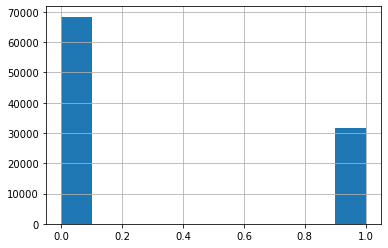

In [20]:
submission[TARGET].hist()